# Discontinuity Analysis

In [1]:
#Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
sns.set(style="whitegrid")
import kernels
# Show data without scientific notation
pd.set_option('display.float_format', lambda x: '%.3f' % x)

## Kernel weighted RD

In [2]:
class Kernels:
    def __init__(self):
        pass
        

    # Triangular kernel
    def triangular_kernel(R, c, h):
        indicator = (np.abs(R - c) <= h).astype(float)
        return indicator * (1 - np.abs(R - c) / h)
    
    # Epanechnikov kernel
    def epanechnikov_kernel(R, c, h):
        indicator = (np.abs(R - c) <= h).astype(float)
        return indicator * (3/4) * (1 - ((R - c) / h) ** 2)
    

# Plotting Dataframe Generation

In [3]:
# Generate Plotting Dataframe
def generate_plotting_df(data):
    cutoff = 0
    bandwidth = 10000
    bin_size = 20

    # Filter out the outliers
    plotting_df = data.copy()
    plotting_df = plotting_df[(plotting_df['dollars_to_goal'] <= bandwidth) & (plotting_df['dollars_to_goal'] >= -bandwidth)]

    # Split data into left and right of the cutoff
    left_df = plotting_df[(plotting_df['state'] == 'failed') & (plotting_df['dollars_to_goal'] < cutoff)]
    right_df = plotting_df[(plotting_df['state'] == 'successful') & (plotting_df['dollars_to_goal'] >= cutoff)]

    # Bin each subset separately
    left_df['dollars_to_goal_binned'] = pd.cut(left_df['dollars_to_goal'], bins=bin_size)
    right_df['dollars_to_goal_binned'] = pd.cut(right_df['dollars_to_goal'], bins=bin_size)

    # Aggregate the binned data for each subset
    left_binned_data = left_df.groupby('dollars_to_goal_binned', observed=False).agg({
        'success_next': 'mean',
        'raised_next_usd': 'mean',
        'goal': 'mean',
        'backers_count': 'mean',
        'staff_pick': 'mean',
        'prelaunch_activated': 'mean',
        'dollars_to_goal': 'size'  # Counts the number of observations in each bin
    }).reset_index().rename(columns={'dollars_to_goal': 'n_obs'})
    right_binned_data = right_df.groupby('dollars_to_goal_binned', observed=False).agg({
        'success_next': 'mean',
        'raised_next_usd': 'mean',
        'goal': 'mean',
        'backers_count': 'mean',
        'staff_pick': 'mean',
        'prelaunch_activated': 'mean',
        'dollars_to_goal': 'size'  # Counts the number of observations in each bin
    }).reset_index().rename(columns={'dollars_to_goal': 'n_obs'})

    # Add a midpoint for each bin for both left and right data
    left_binned_data['dollars_to_goal'] = left_binned_data['dollars_to_goal_binned'].apply(lambda interval: interval.mid)
    right_binned_data['dollars_to_goal'] = right_binned_data['dollars_to_goal_binned'].apply(lambda interval: interval.mid)

    # Combine the binned data for both sides of the cutoff
    plotting_df = pd.concat([left_binned_data, right_binned_data], ignore_index=True)
    return plotting_df

# Load the Data

In [4]:
# Load the data
df = pd.read_json('../data/creator_first_project.json', lines = True)
df.shape

(328652, 148)

Define Running Variable

In [5]:
# Calculate the dollars to goal
df['dollars_to_goal'] = df['usd_pledged']  - df['usd_goal']

# Create threshold Variable
df = df.assign(threshold = (df['dollars_to_goal'] > 0).astype(int)).sort_values('dollars_to_goal').reset_index(drop=True)

# Calculate the dollars to goal times threshold
df['dollars_to_goal*threshold'] = df['dollars_to_goal'] * df['threshold']

# Quadtratic term
df['dollars_to_goal_2'] = df['dollars_to_goal'] ** 2
df['dollars_to_goal_2*threshold'] = df['dollars_to_goal_2'] * df['threshold']

# Key Statistics

In [6]:
# Check success next statistics
df[['usd_goal', 'usd_pledged', 'dollars_to_goal', 'staff_pick', 'backers_count']].describe()

,usd_goal,usd_pledged,dollars_to_goal,staff_pick,backers_count
count,328652.000,328652.000,328652.000,321019.000,328652.000
mean,39749.071,12231.960,-27517.111,0.115,129.538
std,1049282.913,97368.424,1053242.408,0.319,936.501
min,0.511,0.000,-152350076.000,0.000,0.000
25%,2000.000,73.214,-7000.000,0.000,3.000
50%,5000.000,1228.000,-50.000,0.000,21.000
75%,15000.000,6055.000,620.993,0.000,77.000
max,152350076.000,13285226.360,13235226.360,1.000,219382.000


In [7]:
# Replace nas with 0
filled_df = df.copy()
filled_df['success_next'] = filled_df['success_next'].fillna(0)

# Generate Plotting Dataframe

In [8]:
plotting_df = generate_plotting_df(df)

C:\Users\d0tam\AppData\Local\Temp\ipykernel_36464\3626772908.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  left_df['dollars_to_goal_binned'] = pd.cut(left_df['dollars_to_goal'], bins=bin_size)
C:\Users\d0tam\AppData\Local\Temp\ipykernel_36464\3626772908.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  right_df['dollars_to_goal_binned'] = pd.cut(right_df['dollars_to_goal'], bins=bin_size)


In [9]:
# Describe success_next
plotting_df


,dollars_to_goal_binned,success_next,raised_next_usd,goal,backers_count,staff_pick,prelaunch_activated,n_obs,dollars_to_goal
0,"(-10010.0, -9500.0]",0.184,1393.830,12736.141,5.683,0.011,0.080,6489,-9755.000
1,"(-9500.0, -9000.001]",0.500,4851.499,19623.093,18.209,0.046,0.156,1543,-9250.001
2,"(-9000.001, -8500.001]",0.450,4915.541,16377.204,19.113,0.047,0.121,1663,-8750.001
3,"(-8500.001, -8000.002]",0.429,3643.219,19985.869,20.150,0.049,0.130,1431,-8250.002
4,"(-8000.002, -7500.002]",0.332,2275.477,12199.663,12.762,0.029,0.103,2673,-7750.002
5,"(-7500.002, -7000.003]",0.321,2738.481,14694.770,13.611,0.043,0.098,2350,-7250.003
6,"(-7000.003, -6500.003]",0.354,3243.223,11549.844,14.811,0.038,0.117,2479,-6750.003
7,"(-6500.003, -6000.004]",0.418,2674.928,13142.336,15.791,0.036,0.116,2087,-6250.003
8,"(-6000.004, -5500.004]",0.369,3785.369,10746.275,12.472,0.038,0.103,3012,-5750.004
9,"(-5500.004, -5000.005]",0.411,2265.752,12053.622,15.408,0.047,0.117,2398,-5250.005


## Plot Next Project Success by Dollars to Goal

Text(0.5, 1.0, 'Probability of Next Project Success by Dollars to Goal')

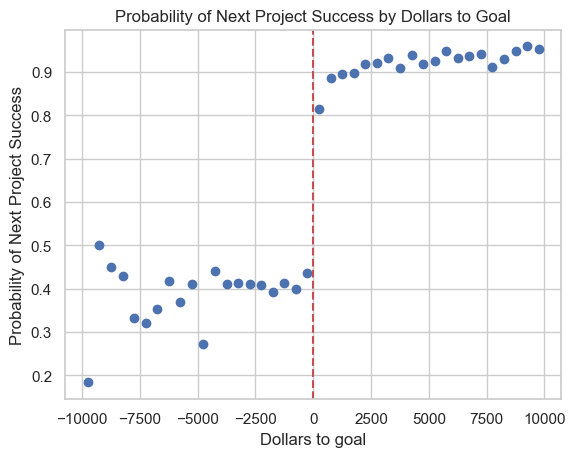

In [10]:
cutoff = 0
plt.figure()
plt.plot(plotting_df['dollars_to_goal'], plotting_df['success_next'], 'o')
plt.axvline(x=cutoff, color='r', linestyle='--')
plt.xlabel('Dollars to goal')
plt.ylabel('Probability of Next Project Success')
plt.title('Probability of Next Project Success by Dollars to Goal')

# Effect on Success Next

## Naive Model

Drop NAs from Main Dataframe

In [11]:
# Create df with no NAs in success_next
ml_df = df.dropna(subset=['success_next'])

In [12]:

# Fit the model
X = ml_df[['dollars_to_goal', 'threshold', 'dollars_to_goal*threshold']]
y = ml_df['success_next']

model = LogisticRegression(fit_intercept=True, verbose = 1).fit(X,y)

# Print param names and coefficients
coef_dict = {}
for coef, feat in zip(model.coef_[0,:], model.feature_names_in_):
    coef_dict[feat] = "{:.10f}".format(coef)

coef_dict

{'dollars_to_goal': '0.0000015681',
 'threshold': '2.6021127538',
 'dollars_to_goal*threshold': '0.0000078132'}

In [13]:
table_model = smf.glm('success_next ~ dollars_to_goal + threshold + dollars_to_goal*threshold', 
                family = sm.families.Binomial(), 
                data = df).fit()

table_model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:           success_next   No. Observations:                45300
Model:                            GLM   Df Residuals:                    45296
Model Family:                Binomial   Df Model:                            3
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -20330.
Date:                Tue, 10 Dec 2024   Deviance:                       40659.
Time:                        10:32:58   Pearson chi2:                 7.36e+14
No. Iterations:                     9   Pseudo R-squ. (CS):             0.2847
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                    -0.6164      0.017    -35.279      0.000      -0.651      -0.582
dollars_to_goal            1.565e-06   2.27e-07      6.900      0.000    1.12e-06    2.01e-06
threshold                     2.6039      0.026     98.569      0.000       2.552       2.656
dollars_to_goal:threshold    7.8e-06   9.84e-07      7.928      0.000    5.87e-06    9.73e-06
=============================================================================================
"""

In [14]:
# Get the percent change in probability from log odds
print(f"Threshold Parameter: {model.coef_[0,1]:.5f}")
probability = np.exp(model.coef_[0,1]) - 1
print(f"Change in probability of success: {probability:.2f}%")

Threshold Parameter: 2.60211
Change in probability of success: 12.49%


In [15]:
plotting_df = generate_plotting_df(df)

C:\Users\d0tam\AppData\Local\Temp\ipykernel_36464\3626772908.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  left_df['dollars_to_goal_binned'] = pd.cut(left_df['dollars_to_goal'], bins=bin_size)
C:\Users\d0tam\AppData\Local\Temp\ipykernel_36464\3626772908.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  right_df['dollars_to_goal_binned'] = pd.cut(right_df['dollars_to_goal'], bins=bin_size)


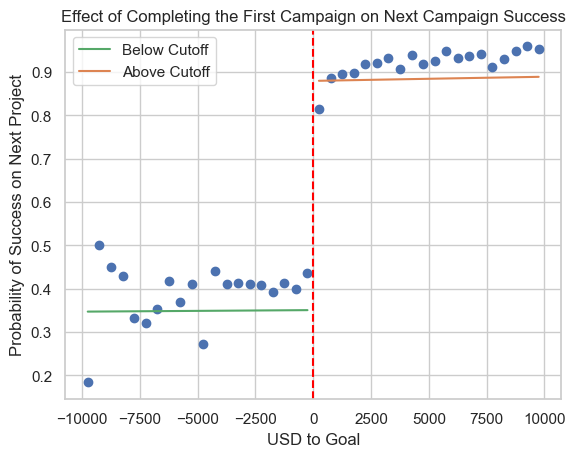

In [16]:
# Remove outliers
plt.figure()
plt.scatter(plotting_df['dollars_to_goal'], plotting_df['success_next'], color = "C0")
#ax = plotting_df.plot.scatter(x = 'dollars_to_goal', y = 'success_next', color = "C0")

# Create threshold and Interaction Variable
cutoff = 0
plotting_df['threshold'] = 0
plotting_df.loc[plotting_df['dollars_to_goal'] > cutoff, 'threshold'] = 1

# Convert threshold to int
plotting_df['threshold'] = plotting_df['threshold'].astype(int)
plotting_df['dollars_to_goal*threshold'] = plotting_df['dollars_to_goal'] * plotting_df['threshold']

exog_dict = plotting_df[['dollars_to_goal', 'threshold', 'dollars_to_goal*threshold']]
plotting_df['predictions'] = model.predict_proba(exog_dict)[:,1]
left_plotting_df = plotting_df[plotting_df['dollars_to_goal'] < cutoff]
right_plotting_df = plotting_df[plotting_df['dollars_to_goal'] >= cutoff]
plt.plot(left_plotting_df['dollars_to_goal'], left_plotting_df['predictions'], color = 'C2', label = 'Below Cutoff')
plt.plot(right_plotting_df['dollars_to_goal'], right_plotting_df['predictions'], color = 'C1', label = 'Above Cutoff')
plt.legend()
plt.axvline(x = 1, color = 'red', linestyle = '--')
plt.ylabel('Probability of Success on Next Project')
plt.xlabel('USD to Goal')
plt.title('Effect of Completing the First Campaign on Next Campaign Success')

plt.savefig('../images/next_kickstarter/effect_of_completing_the_first_campaign_on_next_campaign_success.png')
plt.show()


## Including Quitters

In [17]:
plotting_df = generate_plotting_df(filled_df)

C:\Users\d0tam\AppData\Local\Temp\ipykernel_36464\3626772908.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  left_df['dollars_to_goal_binned'] = pd.cut(left_df['dollars_to_goal'], bins=bin_size)
C:\Users\d0tam\AppData\Local\Temp\ipykernel_36464\3626772908.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  right_df['dollars_to_goal_binned'] = pd.cut(right_df['dollars_to_goal'], bins=bin_size)


In [18]:
# Create threshold Variable
filled_df = filled_df.assign(threshold = (filled_df['dollars_to_goal'] > 0).astype(int)).sort_values('dollars_to_goal').reset_index(drop=True)
# Calculate the dollars to goal times threshold
filled_df['dollars_to_goal*threshold'] = filled_df['dollars_to_goal'] * filled_df['threshold']

In [19]:
X = filled_df[['dollars_to_goal', 'threshold', 'dollars_to_goal*threshold']]
y = filled_df['success_next']

model = LogisticRegression(fit_intercept=True, verbose = 1).fit(X,y)

# Print param names and coefficients
coef_dict = {}
for coef, feat in zip(model.coef_[0,:], model.feature_names_in_):
    coef_dict[feat] = "{:.10f}".format(coef)

coef_dict

{'dollars_to_goal': '0.0000013473',
 'threshold': '1.7017218880',
 'dollars_to_goal*threshold': '-0.0000005472'}

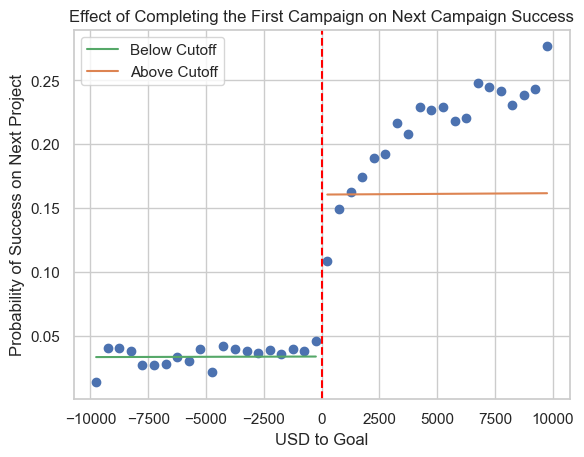

In [20]:
# Remove outliers
plt.figure()
plt.scatter(plotting_df['dollars_to_goal'], plotting_df['success_next'], color = "C0")
#ax = plotting_df.plot.scatter(x = 'dollars_to_goal', y = 'success_next', color = "C0")

# Create threshold and Interaction Variable
cutoff = 0
plotting_df['threshold'] = 0
plotting_df.loc[plotting_df['dollars_to_goal'] > cutoff, 'threshold'] = 1

# Convert threshold to int
plotting_df['threshold'] = plotting_df['threshold'].astype(int)
plotting_df['dollars_to_goal*threshold'] = plotting_df['dollars_to_goal'] * plotting_df['threshold']

exog_dict = plotting_df[['dollars_to_goal', 'threshold', 'dollars_to_goal*threshold']]
plotting_df['predictions'] = model.predict_proba(exog_dict)[:,1]
left_plotting_df = plotting_df[plotting_df['dollars_to_goal'] < cutoff]
right_plotting_df = plotting_df[plotting_df['dollars_to_goal'] >= cutoff]
plt.plot(left_plotting_df['dollars_to_goal'], left_plotting_df['predictions'], color = 'C2', label = 'Below Cutoff')
plt.plot(right_plotting_df['dollars_to_goal'], right_plotting_df['predictions'], color = 'C1', label = 'Above Cutoff')
plt.legend()
plt.axvline(x = 1, color = 'red', linestyle = '--')
plt.ylabel('Probability of Success on Next Project')
plt.xlabel('USD to Goal')
plt.title('Effect of Completing the First Campaign on Next Campaign Success')

plt.savefig('../images/next_kickstarter/effect_of_completing_the_first_campaign_on_next_campaign_success.png')
plt.show()


## RD with Kernel

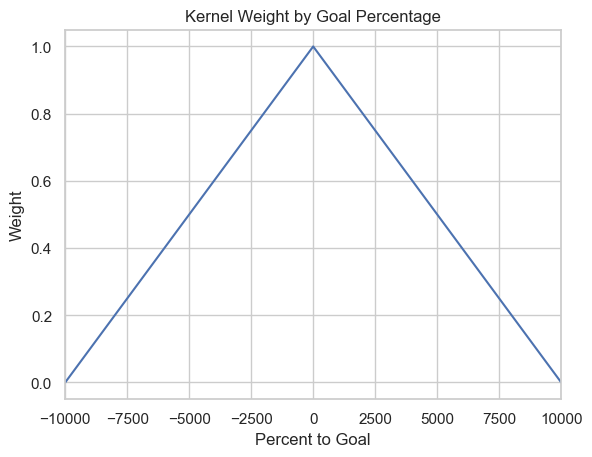

In [21]:
bandwidth = 10000
plt.plot(sorted(ml_df["dollars_to_goal"]), Kernels.triangular_kernel(ml_df["dollars_to_goal"], c=cutoff, h=bandwidth), label="Triangular Kernel")
plt.xlabel("Percent to Goal")
plt.ylabel("Weight")
plt.xlim(-bandwidth, bandwidth)
plt.title("Kernel Weight by Goal Percentage");

In [22]:
X, y = ml_df[['dollars_to_goal', 'threshold', 'dollars_to_goal*threshold']], ml_df['success_next']
cutoff = 0
bandwidth = 10000
model = LogisticRegression(fit_intercept=True, verbose = 1).fit(X,y, sample_weight=Kernels.triangular_kernel(ml_df['dollars_to_goal'], c=cutoff, h=bandwidth))

# Print param names and coefficients
coef_dict = {}
for coef, feat in zip(model.coef_[0,:], model.feature_names_in_):
    coef_dict[feat] = "{:.10f}".format(coef)

coef_dict

{'dollars_to_goal': '0.0000833653',
 'threshold': '1.7300048281',
 'dollars_to_goal*threshold': '0.0002019925'}

In [23]:
cutoff = 0
bandwidth = 10000
table_model = smf.glm('success_next ~ dollars_to_goal + threshold + dollars_to_goal*threshold', 
                family = sm.families.Binomial(), 
                data = df, 
                freq_weights = Kernels.triangular_kernel(df['dollars_to_goal'], c = cutoff, h = bandwidth)
                ).fit()

table_model.summary()


c:\Users\d0tam\kickstarter-JMP\.venv\Lib\site-packages\statsmodels\genmod\families\links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
c:\Users\d0tam\kickstarter-JMP\.venv\Lib\site-packages\statsmodels\genmod\families\family.py:1056: RuntimeWarning: divide by zero encountered in log
  special.gammaln(n - y + 1) + y * np.log(mu / (1 - mu + 1e-20)) +
c:\Users\d0tam\kickstarter-JMP\.venv\Lib\site-packages\statsmodels\genmod\families\family.py:1056: RuntimeWarning: invalid value encountered in multiply
  special.gammaln(n - y + 1) + y * np.log(mu / (1 - mu + 1e-20)) +
c:\Users\d0tam\kickstarter-JMP\.venv\Lib\site-packages\statsmodels\genmod\families\family.py:329: RuntimeWarning: invalid value encountered in multiply
  return np.sum(ll_obs * freq_weights)


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:           success_next   No. Observations:                45300
Model:                            GLM   Df Residuals:                 26078.48
Model Family:                Binomial   Df Model:                            3
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                    nan
Date:                Tue, 10 Dec 2024   Deviance:                       24297.
Time:                        10:33:04   Pearson chi2:                 2.66e+04
No. Iterations:                     6   Pseudo R-squ. (CS):                nan
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                    -0.1579      0.037     -4.288      0.000      -0.230      -0.086
dollars_to_goal            8.277e-05   1.27e-05      6.535      0.000    5.79e-05       0.000
threshold                     1.7335      0.045     38.312      0.000       1.645       1.822
dollars_to_goal:threshold     0.0002    2.4e-05      8.431      0.000       0.000       0.000
=============================================================================================
"""

In [24]:
plotting_df = generate_plotting_df(df)

C:\Users\d0tam\AppData\Local\Temp\ipykernel_36464\3626772908.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  left_df['dollars_to_goal_binned'] = pd.cut(left_df['dollars_to_goal'], bins=bin_size)
C:\Users\d0tam\AppData\Local\Temp\ipykernel_36464\3626772908.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  right_df['dollars_to_goal_binned'] = pd.cut(right_df['dollars_to_goal'], bins=bin_size)


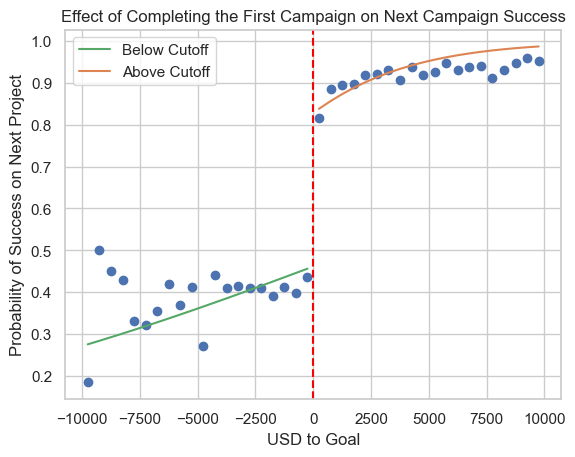

In [25]:
# Remove outliers
plt.figure()
plt.scatter(plotting_df['dollars_to_goal'], plotting_df['success_next'], color = "C0")
#ax = plotting_df.plot.scatter(x = 'dollars_to_goal', y = 'success_next', color = "C0")

# Create threshold and Interaction Variable
cutoff = 0
plotting_df['threshold'] = 0
plotting_df.loc[plotting_df['dollars_to_goal'] > cutoff, 'threshold'] = 1

# Convert threshold to int
plotting_df['threshold'] = plotting_df['threshold'].astype(int)
plotting_df['dollars_to_goal*threshold'] = plotting_df['dollars_to_goal'] * plotting_df['threshold']

exog_dict = plotting_df[['dollars_to_goal', 'threshold', 'dollars_to_goal*threshold']]
plotting_df['predictions'] = model.predict_proba(exog_dict)[:,1]
left_plotting_df = plotting_df[plotting_df['dollars_to_goal'] < cutoff]
right_plotting_df = plotting_df[plotting_df['dollars_to_goal'] >= cutoff]
plt.plot(left_plotting_df['dollars_to_goal'], left_plotting_df['predictions'], color = 'C2', label = 'Below Cutoff')
plt.plot(right_plotting_df['dollars_to_goal'], right_plotting_df['predictions'], color = 'C1', label = 'Above Cutoff')
plt.legend()
plt.axvline(x = 1, color = 'red', linestyle = '--')
plt.ylabel('Probability of Success on Next Project')
plt.xlabel('USD to Goal')
plt.title('Effect of Completing the First Campaign on Next Campaign Success')

plt.savefig('../images/next_kickstarter/effect_of_completing_the_first_campaign_on_next_campaign_success_with_kernel.png')
plt.show()


## RD with Controls and Weights

In [26]:
weights = Kernels.triangular_kernel(df['dollars_to_goal'], c = cutoff, h = bandwidth)
weights[weights == 0] = 1e-10

all_categories = sorted(df['category_name'].unique())

model = smf.glm('success_next ~ dollars_to_goal + threshold + dollars_to_goal*threshold + goal + backers_count + staff_pick + prelaunch_activated + C(category_name, levels=all_categories)', 
                family = sm.families.Binomial(), 
                data = df, 
                freq_weights = weights).fit()

model.summary().tables[1]


c:\Users\d0tam\kickstarter-JMP\.venv\Lib\site-packages\statsmodels\genmod\families\links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
c:\Users\d0tam\kickstarter-JMP\.venv\Lib\site-packages\statsmodels\genmod\families\family.py:1056: RuntimeWarning: divide by zero encountered in log
  special.gammaln(n - y + 1) + y * np.log(mu / (1 - mu + 1e-20)) +
c:\Users\d0tam\kickstarter-JMP\.venv\Lib\site-packages\statsmodels\genmod\families\family.py:1056: RuntimeWarning: invalid value encountered in multiply
  special.gammaln(n - y + 1) + y * np.log(mu / (1 - mu + 1e-20)) +


,coef,std err,z,P>|z|,[0.025,0.975]
Intercept,-0.5712,0.354,-1.613,0.107,-1.265,0.123
"C(category_name, levels=all_categories)[T.Academic]",-0.3653,0.464,-0.788,0.431,-1.274,0.544
"C(category_name, levels=all_categories)[T.Accessories]",1.6191,0.469,3.453,0.001,0.700,2.538
"C(category_name, levels=all_categories)[T.Action]",-0.9717,0.534,-1.818,0.069,-2.019,0.076
"C(category_name, levels=all_categories)[T.Animals]",-0.2365,0.689,-0.343,0.731,-1.586,1.113
"C(category_name, levels=all_categories)[T.Animation]",-0.3956,0.417,-0.948,0.343,-1.214,0.423
"C(category_name, levels=all_categories)[T.Anthologies]",1.5184,0.422,3.597,0.000,0.691,2.346
"C(category_name, levels=all_categories)[T.Apparel]",0.3378,0.440,0.768,0.442,-0.524,1.199
"C(category_name, levels=all_categories)[T.Apps]",-1.0074,0.573,-1.758,0.079,-2.131,0.116
"C(category_name, levels=all_categories)[T.Architecture]",0.1733,0.595,0.291,0.771,-0.993,1.340


## RD with Quadratic

In [27]:
table_model = smf.glm('success_next ~ dollars_to_goal + dollars_to_goal_2 + threshold + dollars_to_goal*threshold + dollars_to_goal_2*threshold', 
                family = sm.families.Binomial(), 
                data = df
                ).fit()

table_model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:           success_next   No. Observations:                45300
Model:                            GLM   Df Residuals:                    45296
Model Family:                Binomial   Df Model:                            3
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -20313.
Date:                Tue, 10 Dec 2024   Deviance:                       40626.
Time:                        10:33:08   Pearson chi2:                 4.73e+14
No. Iterations:                    40   Pseudo R-squ. (CS):             0.2853
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                      -0.6111      0.018    -34.844      0.000      -0.645      -0.577
dollars_to_goal              1.795e-06   2.43e-07      7.380      0.000    1.32e-06    2.27e-06
dollars_to_goal_2            1.166e-14   1.62e-15      7.198      0.000    8.48e-15    1.48e-14
threshold                       2.5914      0.026     97.791      0.000       2.540       2.643
dollars_to_goal:threshold     8.74e-06   1.06e-06      8.222      0.000    6.66e-06    1.08e-05
dollars_to_goal_2:threshold -1.046e-12   1.07e-13     -9.794      0.000   -1.26e-12   -8.37e-13
===============================================================================================
"""

## RD with IK and CCT Bandwidth

In [28]:
from rdd import rdd

In [29]:
ik_bandwidth = rdd.optimal_bandwidth(X = ml_df['dollars_to_goal'], Y = ml_df['success_next'], cut = 0)
print(f"Imbens-Kalyanaraman Optimal Bandwidth: {ik_bandwidth:.2f}")

Imbens-Kalyanaraman Optimal Bandwidth: 14.18


In [30]:
bandwidth_data = rdd.truncated_data(ml_df, xname = 'dollars_to_goal', bandwidth=ik_bandwidth, yname = 'success_next', cut = 0)

# Print data shape based on dollars_to_goal variable less than 0 and greater than or equal to 0
print(f"Data Shape: {bandwidth_data.shape}")
print(f"Before Cutoff Data Shape: {bandwidth_data[bandwidth_data['dollars_to_goal'] < 0].shape}")
print(f"After Cutoff Data Shape: {bandwidth_data[bandwidth_data['dollars_to_goal'] >= 0].shape}")

bandwidth_data

Data Shape: (1095, 153)
Before Cutoff Data Shape: (13, 153)
After Cutoff Data Shape: (1082, 153)


,id,photo_key,photo_full,photo_ed,photo_med,photo_little,photo_small,photo_thumb,photo_1024x576,photo_1536x864,...,total_failed_after_first_3,total_canceled_after_first_3,total_campaigns_after_first_3,total_raised_after_first_3,total_raised_after_first_usd_3,dollars_to_goal,threshold,dollars_to_goal*threshold,dollars_to_goal_2,dollars_to_goal_2*threshold
164894,632204945,assets/011/771/666/ddec92bd620a8cfeabc0755da3d...,https://ksr-ugc.imgix.net/assets/011/771/666/d...,https://ksr-ugc.imgix.net/assets/011/771/666/d...,https://ksr-ugc.imgix.net/assets/011/771/666/d...,https://ksr-ugc.imgix.net/assets/011/771/666/d...,https://ksr-ugc.imgix.net/assets/011/771/666/d...,https://ksr-ugc.imgix.net/assets/011/771/666/d...,https://ksr-ugc.imgix.net/assets/011/771/666/d...,https://ksr-ugc.imgix.net/assets/011/771/666/d...,...,1.000,NaN,1.000,NaN,NaN,-13.608,0,-0.000,185.168,0.000
164911,565824373,projects/647080/photo-original.JPG,https://ksr-ugc.imgix.net/projects/647080/phot...,https://ksr-ugc.imgix.net/projects/647080/phot...,https://ksr-ugc.imgix.net/projects/647080/phot...,https://ksr-ugc.imgix.net/projects/647080/phot...,https://ksr-ugc.imgix.net/projects/647080/phot...,https://ksr-ugc.imgix.net/projects/647080/phot...,None,None,...,1.000,NaN,1.000,NaN,NaN,-11.000,0,-0.000,121.000,0.000
164914,1965872837,assets/039/271/867/e8eb25d6dfb8d8022c1c47a0f09...,https://i.kickstarter.com/assets/039/271/867/e...,https://i.kickstarter.com/assets/039/271/867/e...,https://i.kickstarter.com/assets/039/271/867/e...,https://i.kickstarter.com/assets/039/271/867/e...,https://i.kickstarter.com/assets/039/271/867/e...,https://i.kickstarter.com/assets/039/271/867/e...,https://i.kickstarter.com/assets/039/271/867/e...,https://i.kickstarter.com/assets/039/271/867/e...,...,NaN,NaN,1.000,12962.000,14136.472,-10.932,0,-0.000,119.511,0.000
164928,1391660815,projects/895331/photo-original.jpg,https://ksr-ugc.imgix.net/projects/895331/phot...,https://ksr-ugc.imgix.net/projects/895331/phot...,https://ksr-ugc.imgix.net/projects/895331/phot...,https://ksr-ugc.imgix.net/projects/895331/phot...,https://ksr-ugc.imgix.net/projects/895331/phot...,https://ksr-ugc.imgix.net/projects/895331/phot...,None,None,...,1.000,NaN,1.000,NaN,NaN,-10.000,0,-0.000,100.000,0.000
164930,597524977,assets/011/744/370/1bad5b63ec6626aca6c14492638...,https://ksr-ugc.imgix.net/assets/011/744/370/1...,https://ksr-ugc.imgix.net/assets/011/744/370/1...,https://ksr-ugc.imgix.net/assets/011/744/370/1...,https://ksr-ugc.imgix.net/assets/011/744/370/1...,https://ksr-ugc.imgix.net/assets/011/744/370/1...,https://ksr-ugc.imgix.net/assets/011/744/370/1...,https://ksr-ugc.imgix.net/assets/011/744/370/1...,https://ksr-ugc.imgix.net/assets/011/744/370/1...,...,1.000,NaN,1.000,NaN,NaN,-10.000,0,-0.000,100.000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175458,1159113541,assets/011/559/806/e89eac3ca7e47e9ccdab1492834...,https://ksr-ugc.imgix.net/assets/011/559/806/e...,https://ksr-ugc.imgix.net/assets/011/559/806/e...,https://ksr-ugc.imgix.net/assets/011/559/806/e...,https://ksr-ugc.imgix.net/assets/011/559/806/e...,https://ksr-ugc.imgix.net/assets/011/559/806/e...,https://ksr-ugc.imgix.net/assets/011/559/806/e...,https://ksr-ugc.imgix.net/assets/011/559/806/e...,https://ksr-ugc.imgix.net/assets/011/559/806/e...,...,NaN,NaN,NaN,NaN,NaN,14.000,1,14.000,196.000,196.000
175462,251302781,assets/037/295/063/7b8b1281516f85f2901db1f1e02...,https://i.kickstarter.com/assets/037/295/063/7...,https://i.kickstarter.com/assets/037/295/063/7...,https://i.kickstarter.com/assets/037/295/063/7...,https://i.kickstarter.com/assets/037/295/063/7...,https://i.kickstarter.com/assets/037/295/063/7...,https://i.kickstarter.com/assets/037/295/063/7...,https://i.kickstarter.com/assets/037/295/063/7...,https://i.kickstarter.com/assets/037/295/063/7...,...,NaN,NaN,2.000,1231419.000,157284.384,14.014,1,14.014,196.384,196.384
175463,1225891834,assets/037/137/957/3351c6839d38c37505b986

In [31]:
X, y = bandwidth_data[['dollars_to_goal', 'threshold', 'dollars_to_goal*threshold']], bandwidth_data['success_next']
cutoff = 0
model = LogisticRegression(fit_intercept=True, verbose = 1).fit(X,y, sample_weight=Kernels.triangular_kernel(bandwidth_data['dollars_to_goal'], c=cutoff, h=ik_bandwidth))

# Print param names and coefficients
coef_dict = {}
for coef, feat in zip(model.coef_[0,:], model.feature_names_in_):
    coef_dict[feat] = "{:.10f}".format(coef)

coef_dict

{'dollars_to_goal': '0.2149650485',
 'threshold': '0.1139774024',
 'dollars_to_goal*threshold': '-0.1792733322'}

In [32]:
table_model = smf.glm('success_next ~ dollars_to_goal + threshold + dollars_to_goal*threshold ', 
                family = sm.families.Binomial(), 
                data = bandwidth_data,
                freq_weights = Kernels.triangular_kernel(bandwidth_data['dollars_to_goal'], c = cutoff, h = ik_bandwidth)
                ).fit()

table_model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:           success_next   No. Observations:                 1095
Model:                            GLM   Df Residuals:                   785.88
Model Family:                Binomial   Df Model:                            3
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -500.54
Date:                Tue, 10 Dec 2024   Deviance:                       1001.1
Time:                        10:33:08   Pearson chi2:                     790.
No. Iterations:                     4   Pseudo R-squ. (CS):           0.005826
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                     0.5657      0.106      5.315      0.000       0.357       0.774
dollars_to_goal               0.2282      0.183      1.249      0.212      -0.130       0.586
threshold                     0.1187      0.200      0.592      0.554      -0.274       0.512
dollars_to_goal:threshold    -0.1932      0.186     -1.039      0.299      -0.558       0.171
=============================================================================================
"""

In [33]:
plotting_df = generate_plotting_df(ml_df)

C:\Users\d0tam\AppData\Local\Temp\ipykernel_36464\3626772908.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  left_df['dollars_to_goal_binned'] = pd.cut(left_df['dollars_to_goal'], bins=bin_size)
C:\Users\d0tam\AppData\Local\Temp\ipykernel_36464\3626772908.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  right_df['dollars_to_goal_binned'] = pd.cut(right_df['dollars_to_goal'], bins=bin_size)


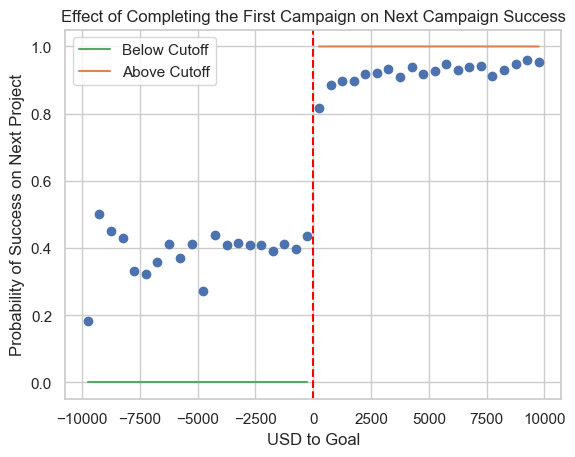

In [34]:
# Remove outliers
plt.figure()
plt.scatter(plotting_df['dollars_to_goal'], plotting_df['success_next'], color = "C0")
#ax = plotting_df.plot.scatter(x = 'dollars_to_goal', y = 'success_next', color = "C0")

# Create threshold and Interaction Variable
cutoff = 0
plotting_df['threshold'] = 0
plotting_df.loc[plotting_df['dollars_to_goal'] > cutoff, 'threshold'] = 1

# Convert threshold to int
plotting_df['threshold'] = plotting_df['threshold'].astype(int)
plotting_df['dollars_to_goal*threshold'] = plotting_df['dollars_to_goal'] * plotting_df['threshold']

exog_dict = plotting_df[['dollars_to_goal', 'threshold', 'dollars_to_goal*threshold']]
plotting_df['predictions'] = model.predict_proba(exog_dict)[:,1]
left_plotting_df = plotting_df[plotting_df['dollars_to_goal'] < cutoff]
right_plotting_df = plotting_df[plotting_df['dollars_to_goal'] >= cutoff]
plt.plot(left_plotting_df['dollars_to_goal'], left_plotting_df['predictions'], color = 'C2', label = 'Below Cutoff')
plt.plot(right_plotting_df['dollars_to_goal'], right_plotting_df['predictions'], color = 'C1', label = 'Above Cutoff')
plt.legend()
plt.axvline(x = 0, color = 'red', linestyle = '--')
plt.ylabel('Probability of Success on Next Project')
plt.xlabel('USD to Goal')
plt.title('Effect of Completing the First Campaign on Next Campaign Success')

#plt.savefig('../images/next_kickstarter/effect_of_completing_the_first_campaign_on_next_campaign_success_with_kernel.png')
plt.show()


CCT Bandwidth

In [35]:
from rdrobust import rdbwselect

In [36]:
print(rdbwselect(y=df['success_next'], x=df['dollars_to_goal'], all=True))

Mass points detected in the running variable.
Call: rdbwselect
Number of Observations:                 45300
Polynomial Order Est. (p):                  1
Polynomial Order Bias (q):                  2
Kernel:                            Triangular
Bandwidth Selection:                      All
Var-Cov Estimator:                         NN

          h (left)  h (right)   b (left)  b (right)
mserd    18349.535  18349.535 145061.950 145061.950
msetwo   48189.322  13467.613 616233.547 114310.583
msesum   31853.803  31853.803 186689.242 186689.242
msecomb1 18349.535  18349.535 145061.950 145061.950
msecomb2 31853.803  18349.535 186689.242 145061.950
cerrd    10735.447  10735.447 145061.950 145061.950
certwo   28193.299   7879.265 616233.547 114310.583
cersum   18636.158  18636.158 186689.242 186689.242
cercomb1 10735.447  10735.447 145061.950 145061.950
cercomb2 18636.158  10735.447 186689.242 145061.950



In [37]:
bandwidth_cct = 18349.535

X, y = ml_df[['dollars_to_goal', 'threshold', 'dollars_to_goal*threshold']], ml_df['success_next']
cutoff = 0
model = LogisticRegression(fit_intercept=True, verbose = 1).fit(X,y, sample_weight=Kernels.triangular_kernel(ml_df['dollars_to_goal'], c=cutoff, h=bandwidth_cct))

# Print param names and coefficients
coef_dict = {}
for coef, feat in zip(model.coef_[0,:], model.feature_names_in_):
    coef_dict[feat] = "{:.10f}".format(coef)

coef_dict


{'dollars_to_goal': '0.0000577125',
 'threshold': '1.8604764265',
 'dollars_to_goal*threshold': '0.0001288427'}

In [38]:
weights = Kernels.triangular_kernel(ml_df['dollars_to_goal'], c = cutoff, h = bandwidth_cct)
weights[weights == 0] = 1e-10

table_model = smf.glm('success_next ~ dollars_to_goal + threshold + dollars_to_goal*threshold ', 
                family = sm.families.Binomial(), 
                data = ml_df,
                freq_weights = weights
                ).fit()

table_model.summary()


c:\Users\d0tam\kickstarter-JMP\.venv\Lib\site-packages\statsmodels\genmod\families\links.py:198: RuntimeWarning: overflow encountered in exp
c:\Users\d0tam\kickstarter-JMP\.venv\Lib\site-packages\statsmodels\genmod\families\family.py:1056: RuntimeWarning: divide by zero encountered in log
c:\Users\d0tam\kickstarter-JMP\.venv\Lib\site-packages\statsmodels\genmod\families\family.py:1056: RuntimeWarning: invalid value encountered in multiply


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:           success_next   No. Observations:                45300
Model:                            GLM   Df Residuals:                 30395.64
Model Family:                Binomial   Df Model:                            3
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                    nan
Date:                Tue, 10 Dec 2024   Deviance:                       28250.
Time:                        10:33:10   Pearson chi2:                 1.51e+07
No. Iterations:                     6   Pseudo R-squ. (CS):                nan
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                    -0.2115      0.031     -6.771      0.000      -0.273      -0.150
dollars_to_goal            5.743e-05   6.89e-06      8.336      0.000    4.39e-05    7.09e-05
threshold                     1.8634      0.040     46.895      0.000       1.786       1.941
dollars_to_goal:threshold     0.0001   1.48e-05      8.700      0.000    9.98e-05       0.000
=============================================================================================
"""

In [39]:
plotting_df = generate_plotting_df(ml_df)

C:\Users\d0tam\AppData\Local\Temp\ipykernel_36464\3626772908.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\d0tam\AppData\Local\Temp\ipykernel_36464\3626772908.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


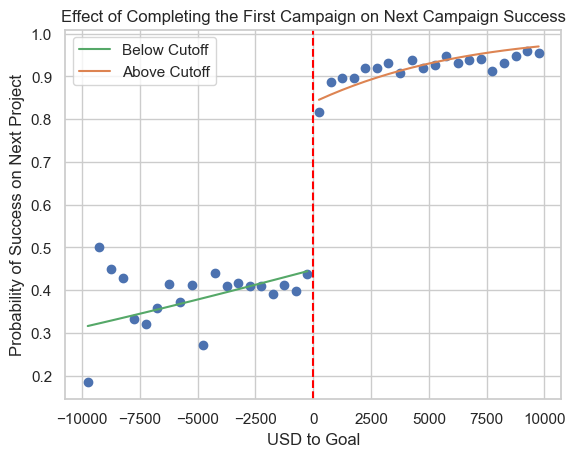

In [40]:
# Remove outliers
plt.figure()
plt.scatter(plotting_df['dollars_to_goal'], plotting_df['success_next'], color = "C0")
#ax = plotting_df.plot.scatter(x = 'dollars_to_goal', y = 'success_next', color = "C0")

# Create threshold and Interaction Variable
cutoff = 0
plotting_df['threshold'] = 0
plotting_df.loc[plotting_df['dollars_to_goal'] > cutoff, 'threshold'] = 1

# Convert threshold to int
plotting_df['threshold'] = plotting_df['threshold'].astype(int)
plotting_df['dollars_to_goal*threshold'] = plotting_df['dollars_to_goal'] * plotting_df['threshold']

exog_dict = plotting_df[['dollars_to_goal', 'threshold', 'dollars_to_goal*threshold']]
plotting_df['predictions'] = model.predict_proba(exog_dict)[:,1]
left_plotting_df = plotting_df[plotting_df['dollars_to_goal'] < cutoff]
right_plotting_df = plotting_df[plotting_df['dollars_to_goal'] >= cutoff]
plt.plot(left_plotting_df['dollars_to_goal'], left_plotting_df['predictions'], color = 'C2', label = 'Below Cutoff')
plt.plot(right_plotting_df['dollars_to_goal'], right_plotting_df['predictions'], color = 'C1', label = 'Above Cutoff')
plt.legend()
plt.axvline(x = 0, color = 'red', linestyle = '--')
plt.ylabel('Probability of Success on Next Project')
plt.xlabel('USD to Goal')
plt.title('Effect of Completing the First Campaign on Next Campaign Success')

plt.savefig('../images/next_kickstarter/cct_bandwidth_next_kickstarter_success.png')
plt.show()


# Raised Next

## Naive Model

In [41]:
# Fit the model
X = ml_df[['dollars_to_goal', 'threshold', 'dollars_to_goal*threshold']]
y = ml_df['raised_next_usd']


model = LinearRegression(fit_intercept=True).fit(X,y)


# Print param names and coefficients
coef_dict = {}
for coef, feat in zip(model.coef_, model.feature_names_in_):
    coef_dict[feat] = "{:.10f}".format(coef)

coef_dict

{'dollars_to_goal': '-0.0000041166',
 'threshold': '4708.6911492285',
 'dollars_to_goal*threshold': '1.0082288861'}

In [42]:
table_model = smf.wls('raised_next_usd ~ dollars_to_goal + threshold + dollars_to_goal*threshold', 
                data = ml_df).fit()

table_model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:        raised_next_usd   R-squared:                       0.331
Model:                            WLS   Adj. R-squared:                  0.331
Method:                 Least Squares   F-statistic:                     7472.
Date:                Tue, 10 Dec 2024   Prob (F-statistic):               0.00
Time:                        10:33:11   Log-Likelihood:            -6.1951e+05
No. Observations:               45300   AIC:                         1.239e+06
Df Residuals:                   45296   BIC:                         1.239e+06
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                  3724.7938   1656.244      2.249      0.025     478.528    6971.060
dollars_to_goal           -4.117e-06      0.001     -0.006      0.996      -0.001       0.001
threshold                  4708.6911   2072.151      2.272      0.023     647.241    8770.142
dollars_to_goal:threshold     1.0082      0.007    148.119      0.000       0.995       1.022
==============================================================================
Omnibus:                   183187.232   Durbin-Watson:                   2.224
Prob(Omnibus):                  0.000   Jarque-Bera (JB):     571088110755.807
Skew:                         105.572   Prob(JB):                         0.00
Kurtosis:                   17396.063   Cond. No.                     3.47e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.47e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

C:\Users\d0tam\AppData\Local\Temp\ipykernel_36464\3626772908.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\d0tam\AppData\Local\Temp\ipykernel_36464\3626772908.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


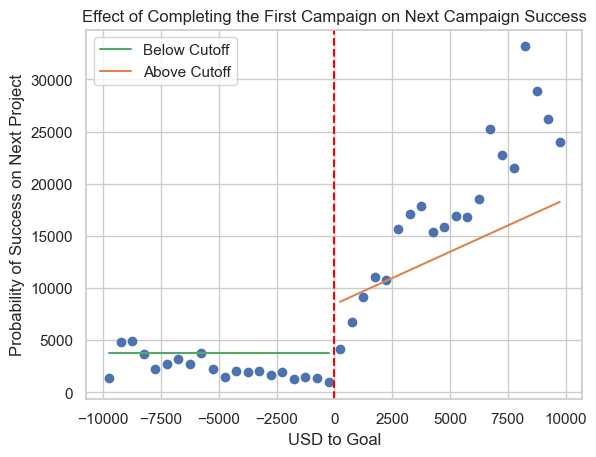

In [43]:
plotting_df = generate_plotting_df(df)
# Remove outliers
plt.figure()
plt.scatter(plotting_df['dollars_to_goal'], plotting_df['raised_next_usd'], color = "C0")
#ax = plotting_df.plot.scatter(x = 'dollars_to_goal', y = 'success_next', color = "C0")

# Create threshold and Interaction Variable
cutoff = 0
plotting_df['threshold'] = 0
plotting_df.loc[plotting_df['dollars_to_goal'] > cutoff, 'threshold'] = 1

# Convert threshold to int
plotting_df['threshold'] = plotting_df['threshold'].astype(int)
plotting_df['dollars_to_goal*threshold'] = plotting_df['dollars_to_goal'] * plotting_df['threshold']

exog_dict = plotting_df[['dollars_to_goal', 'threshold', 'dollars_to_goal*threshold']]
plotting_df['predictions'] = model.predict(exog_dict)
left_plotting_df = plotting_df[plotting_df['dollars_to_goal'] < cutoff]
right_plotting_df = plotting_df[plotting_df['dollars_to_goal'] >= cutoff]
plt.plot(left_plotting_df['dollars_to_goal'], left_plotting_df['predictions'], color = 'C2', label = 'Below Cutoff')
plt.plot(right_plotting_df['dollars_to_goal'], right_plotting_df['predictions'], color = 'C1', label = 'Above Cutoff')
plt.legend()
plt.axvline(x = 1, color = 'red', linestyle = '--')
plt.ylabel('Probability of Success on Next Project')
plt.xlabel('USD to Goal')
plt.title('Effect of Completing the First Campaign on Next Campaign Success')

plt.savefig('../images/next_kickstarter/effect_of_completing_the_first_campaign_on_next_raised.png')
plt.show()


## Triangular Kernel

In [44]:
c = 0
bandwidth = 10000
weights = Kernels.triangular_kernel(ml_df['dollars_to_goal'], c = cutoff, h = bandwidth)

table_model = smf.wls('raised_next_usd ~ dollars_to_goal + threshold + dollars_to_goal*threshold', 
                data = ml_df,
                weights = weights).fit()

table_model.summary()



c:\Users\d0tam\kickstarter-JMP\.venv\Lib\site-packages\statsmodels\regression\linear_model.py:806: RuntimeWarning: divide by zero encountered in log


<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:        raised_next_usd   R-squared:                       0.034
Model:                            WLS   Adj. R-squared:                  0.034
Method:                 Least Squares   F-statistic:                     538.7
Date:                Tue, 10 Dec 2024   Prob (F-statistic):               0.00
Time:                        10:33:13   Log-Likelihood:                   -inf
No. Observations:               45300   AIC:                               inf
Df Residuals:                   45296   BIC:                               inf
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                  1189.0191    343.346      3.463      0.001     516.054    1861.984
dollars_to_goal              -0.2527      0.115     -2.199      0.028      -0.478      -0.027
threshold                  3051.1129    383.286      7.960      0.000    2299.866    3802.359
dollars_to_goal:threshold     3.2949      0.147     22.486      0.000       3.008       3.582
==============================================================================
Omnibus:                   119401.017   Durbin-Watson:                   1.990
Prob(Omnibus):                  0.000   Jarque-Bera (JB):       3825742896.045
Skew:                          31.242   Prob(JB):                         0.00
Kurtosis:                    1425.315   Cond. No.                     1.10e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.1e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Kernel and Controls

In [45]:
weights = Kernels.triangular_kernel(ml_df['dollars_to_goal'], c = cutoff, h = bandwidth)
weights[weights == 0] = 1e-10

all_categories = sorted(ml_df['category_name'].unique())

model = smf.wls('raised_next_usd ~ dollars_to_goal + threshold + dollars_to_goal*threshold + goal + backers_count + staff_pick + prelaunch_activated + C(category_name, levels=all_categories)', 
                data = ml_df, 
                weights = weights).fit()

model.summary().tables[1]


,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,7194.8529,2190.719,3.284,0.001,2900.828,1.15e+04
"C(category_name, levels=all_categories)[T.Academic]",-6226.5175,2879.242,-2.163,0.031,-1.19e+04,-582.921
"C(category_name, levels=all_categories)[T.Accessories]",-8571.3716,2394.556,-3.580,0.000,-1.33e+04,-3877.806
"C(category_name, levels=all_categories)[T.Action]",-7069.6763,3205.596,-2.205,0.027,-1.34e+04,-786.394
"C(category_name, levels=all_categories)[T.Animals]",-8463.5894,4221.235,-2.005,0.045,-1.67e+04,-189.554
"C(category_name, levels=all_categories)[T.Animation]",-5084.3042,2608.543,-1.949,0.051,-1.02e+04,28.696
"C(category_name, levels=all_categories)[T.Anthologies]",-9292.2011,2356.623,-3.943,0.000,-1.39e+04,-4672.988
"C(category_name, levels=all_categories)[T.Apparel]",-2795.7543,2623.457,-1.066,0.287,-7937.987,2346.479
"C(category_name, levels=all_categories)[T.Apps]",-9483.5433,3545.426,-2.675,0.007,-1.64e+04,-2534.159
"C(category_name, levels=all_categories)[T.Architecture]",-6725.8894,3776.103,-1.781,0.075,-1.41e+04,675.644


## Quadratic

In [46]:
model = smf.wls('raised_next_usd ~ dollars_to_goal + threshold + dollars_to_goal*threshold + dollars_to_goal_2 + dollars_to_goal_2*threshold', 
                data = ml_df).fit()

model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:        raised_next_usd   R-squared:                       0.356
Model:                            WLS   Adj. R-squared:                  0.355
Method:                 Least Squares   F-statistic:                     4997.
Date:                Tue, 10 Dec 2024   Prob (F-statistic):               0.00
Time:                        10:33:13   Log-Likelihood:            -6.1867e+05
No. Observations:               45300   AIC:                         1.237e+06
Df Residuals:                   45294   BIC:                         1.237e+06
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                    3711.4010   1628.611      2.279      0.023     519.297    6903.505
dollars_to_goal                -0.0003      0.002     -0.132      0.895      -0.005       0.004
threshold                    1.199e+04   2043.820      5.867      0.000    7984.682     1.6e+04
dollars_to_goal:threshold       0.6165      0.012     52.417      0.000       0.593       0.640
dollars_to_goal_2           -2.761e-12   2.01e-11     -0.137      0.891   -4.22e-11    3.67e-11
dollars_to_goal_2:threshold  8.375e-08   2.02e-09     41.458      0.000    7.98e-08    8.77e-08
==============================================================================
Omnibus:                   179334.753   Durbin-Watson:                   2.346
Prob(Omnibus):                  0.000   Jarque-Bera (JB):     525470852189.856
Skew:                          98.568   Prob(JB):                         0.00
Kurtosis:                   16687.013   Cond. No.                     3.77e+14
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.77e+14. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [47]:
print(model.params)

Intercept                      3711.401
dollars_to_goal                  -0.000
threshold                     11990.603
dollars_to_goal:threshold         0.617
dollars_to_goal_2                -0.000
dollars_to_goal_2:threshold       0.000
dtype: float64


# CATE

## Conditional on Next Goal Intensity

Generate Intensity

In [48]:
# Create new column for ratio of new goal to first goal
df['new_goal/old_goal'] = df['usd_goal_next'] / df['usd_goal']

# Create new column for intensity where intensity is low if it new_goal/old_goal is between 0 and 0.5, medium low if it is between 0.5 and 0.75, same if it is between 0.75 and 1.25, and high if it is greater than 1.25 
df['intensity'] = 'low'
df.loc[(df['new_goal/old_goal'] >= 0.25) & (df['new_goal/old_goal'] < 0.5), 'intensity'] = 'medium low'
df.loc[(df['new_goal/old_goal'] >= 0.50) & (df['new_goal/old_goal'] < 0.75), 'intensity'] = 'medium'
df.loc[(df['new_goal/old_goal'] >= 0.75) & (df['new_goal/old_goal'] < 1), 'intensity'] = 'average'
df.loc[df['new_goal/old_goal'] == 1, 'intensity'] = 'same'
df.loc[(df['new_goal/old_goal'] > 1) & (df['new_goal/old_goal'] < 1.25), 'intensity'] = 'above average'
df.loc[(df['new_goal/old_goal'] >= 1.25) & (df['new_goal/old_goal'] < 1.5), 'intensity'] = 'high'
df.loc[(df['new_goal/old_goal'] >= 1.5) & (df['new_goal/old_goal'] < 2), 'intensity'] = 'very high'
df.loc[df['new_goal/old_goal'] >= 2, 'intensity'] = 'extremely high'



In [49]:
df['new_goal/old_goal'].describe()

count       45300.000
mean         2247.856
std        469866.890
min             0.000
25%             0.403
50%             0.995
75%             1.666
max     100000000.000
Name: new_goal/old_goal, dtype: float64

C:\Users\d0tam\AppData\Local\Temp\ipykernel_36464\4153379123.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


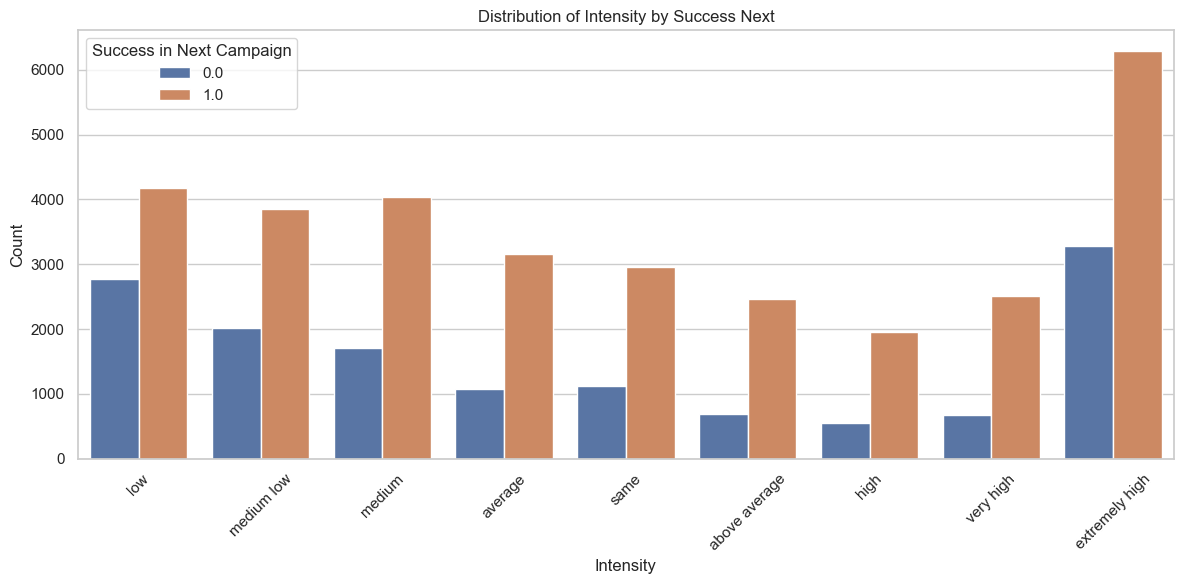

In [50]:
# Drop rows where success_next is NA
plot_intensity = df.dropna(subset=['success_next'])

# Ensure 'intensity' is a categorical column with a specified order
intensity_order = ['low', 'medium low', 'medium', 'average', 'same', 
                   'above average', 'high', 'very high', 'extremely high']
plot_intensity['intensity'] = pd.Categorical(plot_intensity['intensity'], categories=intensity_order, ordered=True)

# Plot using sns.barplot
plt.figure(figsize=(12, 6))
sns.countplot(data=plot_intensity, 
              x='intensity', 
              hue='success_next', 
              order=intensity_order)
plt.xlabel('Intensity')
plt.ylabel('Count')
plt.title('Distribution of Intensity by Success Next')
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility, if needed
plt.legend(title='Success in Next Campaign', loc='upper left')
plt.tight_layout()
plt.show()

NameError: name 'bin_size' is not defined

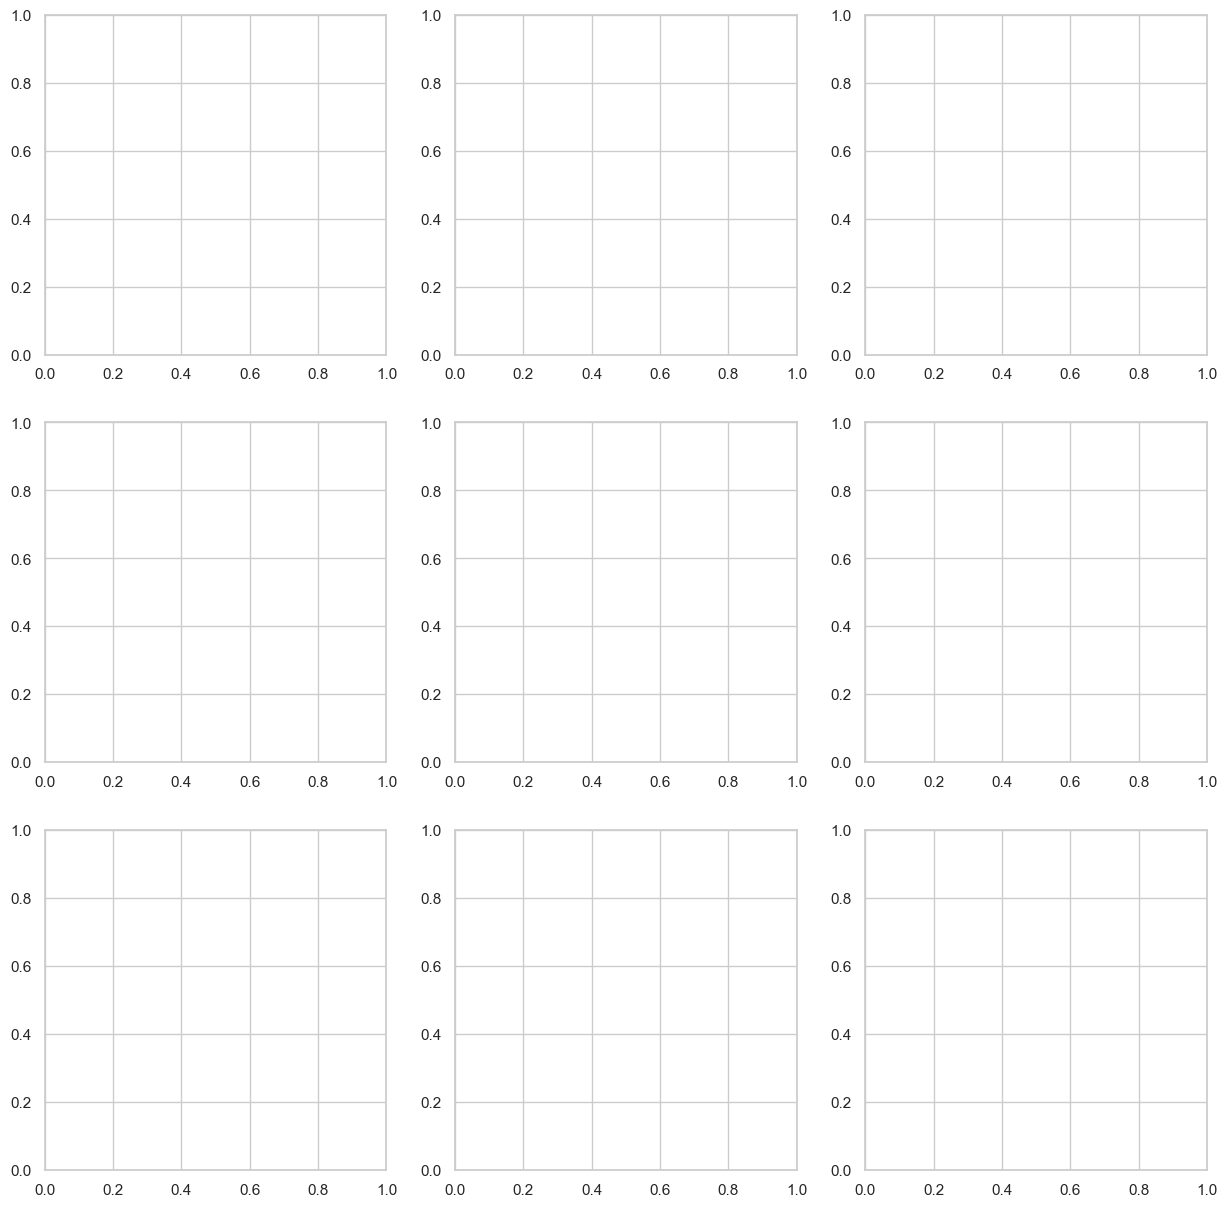

In [51]:
# Create subplots
fig, ax = plt.subplots(3, 3, figsize=(15, 15))

# Flatten the axes array for easier indexing
ax = ax.flatten()

# Iterate through unique intensities and create models
for idx, i in enumerate(df['intensity'].unique()):
    # Ensure you don't exceed subplot limits
    if idx >= len(ax):
        print("Warning: More intensities than subplots available.")
        break

    intensity_df = df[df['intensity'] == i]
    plotting_df = intensity_df[(intensity_df['dollars_to_goal'] <= bandwidth) & (intensity_df['dollars_to_goal'] >= -bandwidth)]

    # Split data into left and right of the cutoff
    left_df = plotting_df[(plotting_df['state'] == 'failed') & (plotting_df['dollars_to_goal'] < cutoff)]
    right_df = plotting_df[(plotting_df['state'] == 'successful') & (plotting_df['dollars_to_goal'] >= cutoff)]

    # Bin each subset separately
    left_df['dollars_to_goal_binned'] = pd.cut(left_df['dollars_to_goal'], bins=bin_size)
    right_df['dollars_to_goal_binned'] = pd.cut(right_df['dollars_to_goal'], bins=bin_size)

    # Aggregate the binned data for each subset
    left_binned_data = left_df.groupby('dollars_to_goal_binned', observed=False).agg({
        'success_next': 'mean',
        'goal': 'mean',
        'backers_count': 'mean',
        'staff_pick': 'mean',
        'prelaunch_activated': 'mean',
        'dollars_to_goal': 'size'  # Counts the number of observations in each bin
    }).reset_index().rename(columns={'dollars_to_goal': 'n_obs'})
    right_binned_data = right_df.groupby('dollars_to_goal_binned', observed=False).agg({
        'success_next': 'mean',
        'goal': 'mean',
        'backers_count': 'mean',
        'staff_pick': 'mean',
        'prelaunch_activated': 'mean',
        'dollars_to_goal': 'size'  # Counts the number of observations in each bin
    }).reset_index().rename(columns={'dollars_to_goal': 'n_obs'})

    # Add a midpoint for each bin for both left and right data
    left_binned_data['dollars_to_goal'] = left_binned_data['dollars_to_goal_binned'].apply(lambda interval: interval.mid)
    right_binned_data['dollars_to_goal'] = right_binned_data['dollars_to_goal_binned'].apply(lambda interval: interval.mid)

    # Combine the binned data for both sides of the cutoff
    plotting_df = pd.concat([left_binned_data, right_binned_data], ignore_index=True)
    plotting_df['threshold'] = 0
    plotting_df.loc[plotting_df['dollars_to_goal'] > cutoff, 'threshold'] = 1
    # Fit the logistic regression model
    model = smf.logit('success_next ~ dollars_to_goal + threshold + dollars_to_goal*threshold', intensity_df).fit()
    print(f"Intensity: {i}")
    print(model.summary().tables[1])
    print("\n")

    # Plot the data and regression discontinuity
    ax[idx].scatter(plotting_df['dollars_to_goal'], plotting_df['success_next'], color="C0")
    ax[idx].plot(plotting_df['dollars_to_goal'], model.predict(plotting_df), color="C1")

    ax[idx].axvline(x=0, color='red', linestyle='--')
    ax[idx].set_title(f'Intensity: {i}')
    ax[idx].set_xlabel('Dollars to Goal')
    ax[idx].set_ylabel('Success Next')

# Adjust layout
plt.tight_layout()
plt.show()

# Models for Table

In [ ]:
# Create threshold square and cubic and their interactions
df['dollars_to_goal_2'] = df['dollars_to_goal'] ** 2
df['dollars_to_goal_3'] = df['dollars_to_goal'] ** 3
df['dollars_to_goal_2*threshold'] = df['dollars_to_goal_2'] * df['threshold']
df['dollars_to_goal_3*threshold'] = df['dollars_to_goal_3'] * df['threshold']


Formulas

In [ ]:
model1 = ['threshold', 'dollars_to_goal']
model2 = ['threshold', 'dollars_to_goal', 'dollars_to_goal*threshold']
model3 = ['threshold', 'dollars_to_goal', 'dollars_to_goal_2']
model4 = ['threshold', 'dollars_to_goal', 'dollars_to_goal_2', 'dollars_to_goal*threshold', 'dollars_to_goal_2*threshold']


models = [model1, model2, model3, model4]

Model

In [ ]:
for i in models:
    X, y = ml_df[X], ml_df['success_next']
    model = LogisticRegression(fit_intercept=True, verbose = 1).fit(X,y)
    print(f"Model: {i}")
    print(f"Threshold Parameter: {model.coef_[0,1]:.5f}")